In [1]:
from graph.operators import invert_edges
from graph.graphutils import flat_graph_formulation
from graph.graphutils import rawvar_nodetyperepr
from graph.graphview import draw

## Multiple outputs

In [2]:
incidence = {
    1: ('a', 'b'),
    2: ('a', 'c')
}

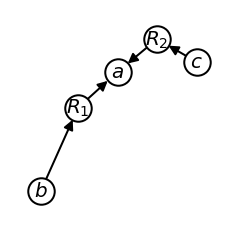

In [3]:
edges = invert_edges(incidence, newout={1:'a', 2:'a'})
G = flat_graph_formulation(*edges, nodetyperepr=rawvar_nodetyperepr)
draw(G, node_shape='o', figsize=(4,4));

## Rearrange

In [4]:
from modeling.compute import Var
from modeling.execution import Component
from modeling.execution import edges_from_components
from graph.graphview import digraph_repr, bipartite_repr
from graph.graphview import drawbipartite
from graph.matrixview import render_incidence
from graph.operators import sort_scc, reorder_merge_solve
import sympy as sp

In [5]:
x, z1, z2 = Var('x'), Var('z_1'), Var('z_2')
y1, y2, f = Var('y_1'), Var('y_2'), Var('f')
eqlist = [
    (y1, z1**2+z2+x-0.2*y2),
    (y2, y1**0.5+z1+z2),
    (f, x**2+z1+y1+sp.exp(-y2))
]

In [6]:

components = [Component.fromsympy(
    right, left, component=idx, arg_mapping=True) for idx, (left, right) in enumerate(eqlist)]
edges = edges_from_components(components)
tree = ({idx:1 for idx in edges[0]},{},{})

In [7]:
incidencestr,_,_ = invert_edges(edges[0], edges[1])
outset = {idx:var[0] for idx,var in edges[1].items()}

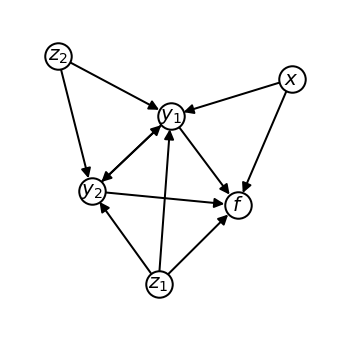

In [8]:
D,_ = digraph_repr(incidencestr, outset)
draw(D, prog='neato', node_shape='o');

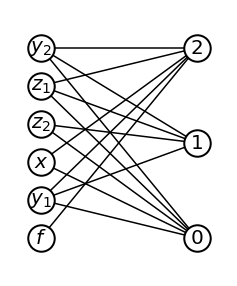

In [9]:
B, _ = bipartite_repr(incidencestr)
drawbipartite(B, node_shape='o')

In [10]:
G = flat_graph_formulation(*edges, nodetyperepr=rawvar_nodetyperepr)
mergeorder = sort_scc(G)
nedges, ntree = reorder_merge_solve(edges, tree, mergeorder, 1)

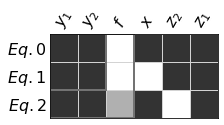

In [11]:
render_incidence(nedges, ntree, 
                 rawvarname=True,
                 hideticks=True, figsize=(3,3));

# Restructure

In [12]:
from presolver.tearing import min_arc_set_assign
from graph.graphutils import edges_E, all_variables, sources
from graph.operators import reformulate
from graph.workflow import get_f
from modeling.transformations import transform_components
from foundations.functionalsets import FunctionalComp
from foundations.functionalsets import ResidualSet
from foundations.functionalsets import FeedForwardSolver

In [13]:
edges_varonleft = edges_E(incidencestr)
eqnidxs= outset.keys()
varidxs = all_variables(edges[0], edges[1])
fixed_inputs = ['z_1']

In [14]:

xsol, model  = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_minassign = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07


In [15]:
edges_minassign=invert_edges(edges[0], edges[1], outset_minassign) 

In [16]:
edges_opt, tree_opt = reformulate(edges, tree, outset, outset_minassign)

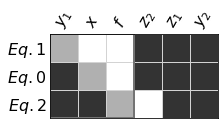

In [17]:
render_incidence(edges_opt, tree_opt, 
                 rawvarname=True,
                 hideticks=True, figsize=(3,3));

In [18]:
arg_mapping = {str(var):var for var in 
               [x, z1, z2, y1, y2, f]}
new_components = transform_components(edges, edges_opt, 
                     components, arg_mapping)

In [19]:
comps = get_f(components+new_components, edges_opt)

In [20]:
all_comps = [comps(compid) 
             for compid in tree_opt[0].keys()]

In [21]:
functionals = [FunctionalComp(comp) for comp in all_comps]
invars = tuple(arg_mapping[elt] for elt in 
          sources(edges_opt[0], edges_opt[1]))

In [22]:
S = ResidualSet(sum([functional.projectable.components 
                     for functional in functionals], []))
F = S.project(invars)
F.solver = FeedForwardSolver(functionals)

In [23]:
functionals[0].projected

(y_2, z_1, z_2)

In [24]:
y = {
    y2: 9.834,
    z1: 2,
    z2: 5
}
z = F.solve(y)    

# Validate results

In [25]:
z

{y_1: DeviceArray(8.031556, dtype=float64),
 x: DeviceArray(0.998356, dtype=float64),
 f: DeviceArray(11.0283243, dtype=float64)}

In [26]:
(functionals[0].solve({**y,**z}),
 functionals[1].solve({**y,**z}),
 functionals[2].solve({**y,**z}))

({y_1: DeviceArray(8.031556, dtype=float64)},
 {x: DeviceArray(0.998356, dtype=float64)},
 {f: DeviceArray(11.0283243, dtype=float64)})